In [ ]:
!pip install numpy pandas matplotlib seaborn sklearn cv2 rasterio

In [1]:
import os

os.chdir("../")

In [2]:
import sys

sys.path.append("src")

In [3]:
from src.dataset_functions import download_data

In [4]:
import yaml

with open("src/config.yaml", "r") as c:
    config = yaml.safe_load(c)

In [5]:
from src.dataset_functions import load_dataset
from pathlib import Path

dataset_folder = Path.cwd() / config["dataset"]["folder"]
dataset_folder.mkdir(exist_ok=True)

species_folders = config["dataset"]["species_folders"]
main_subfolders = config["dataset"]["main_subfolders"]


# Downlaoding data

uncomment if images not downloaded

In [ ]:
# download_data(species_folders, main_subfolders, dataset_folder)

In [ ]:
dataset, label_map = load_dataset(dataset_folder, species_folders)

In [48]:
import pandas as pd

splits = []
for split, values in dataset.items():
    df = pd.DataFrame.from_dict(values)
    df["split"] = split
    splits.append(df)

dataset = pd.concat(splits)

In [51]:
label_to_species = {v: k for k, v in label_map.items()}
dataset["class"] = dataset["labels"].map(label_to_species)
# dataset

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

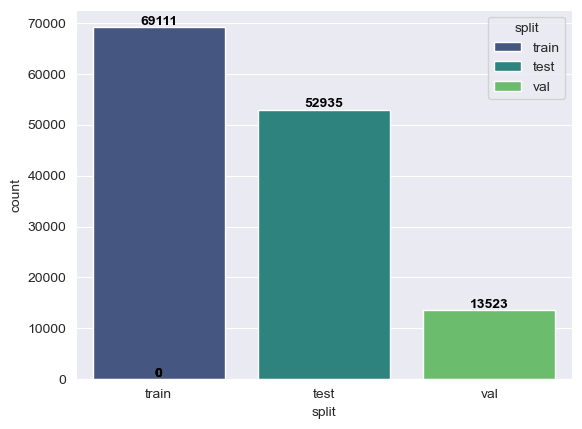

In [101]:
split_counts = dataset["split"].value_counts().reset_index()
split_counts.columns = ["split", "count"]
ax = sns.barplot(data=split_counts, x="split", y="count", palette="viridis", hue="split", legend=True)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2.0, p.get_height()), ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")
plt.show()

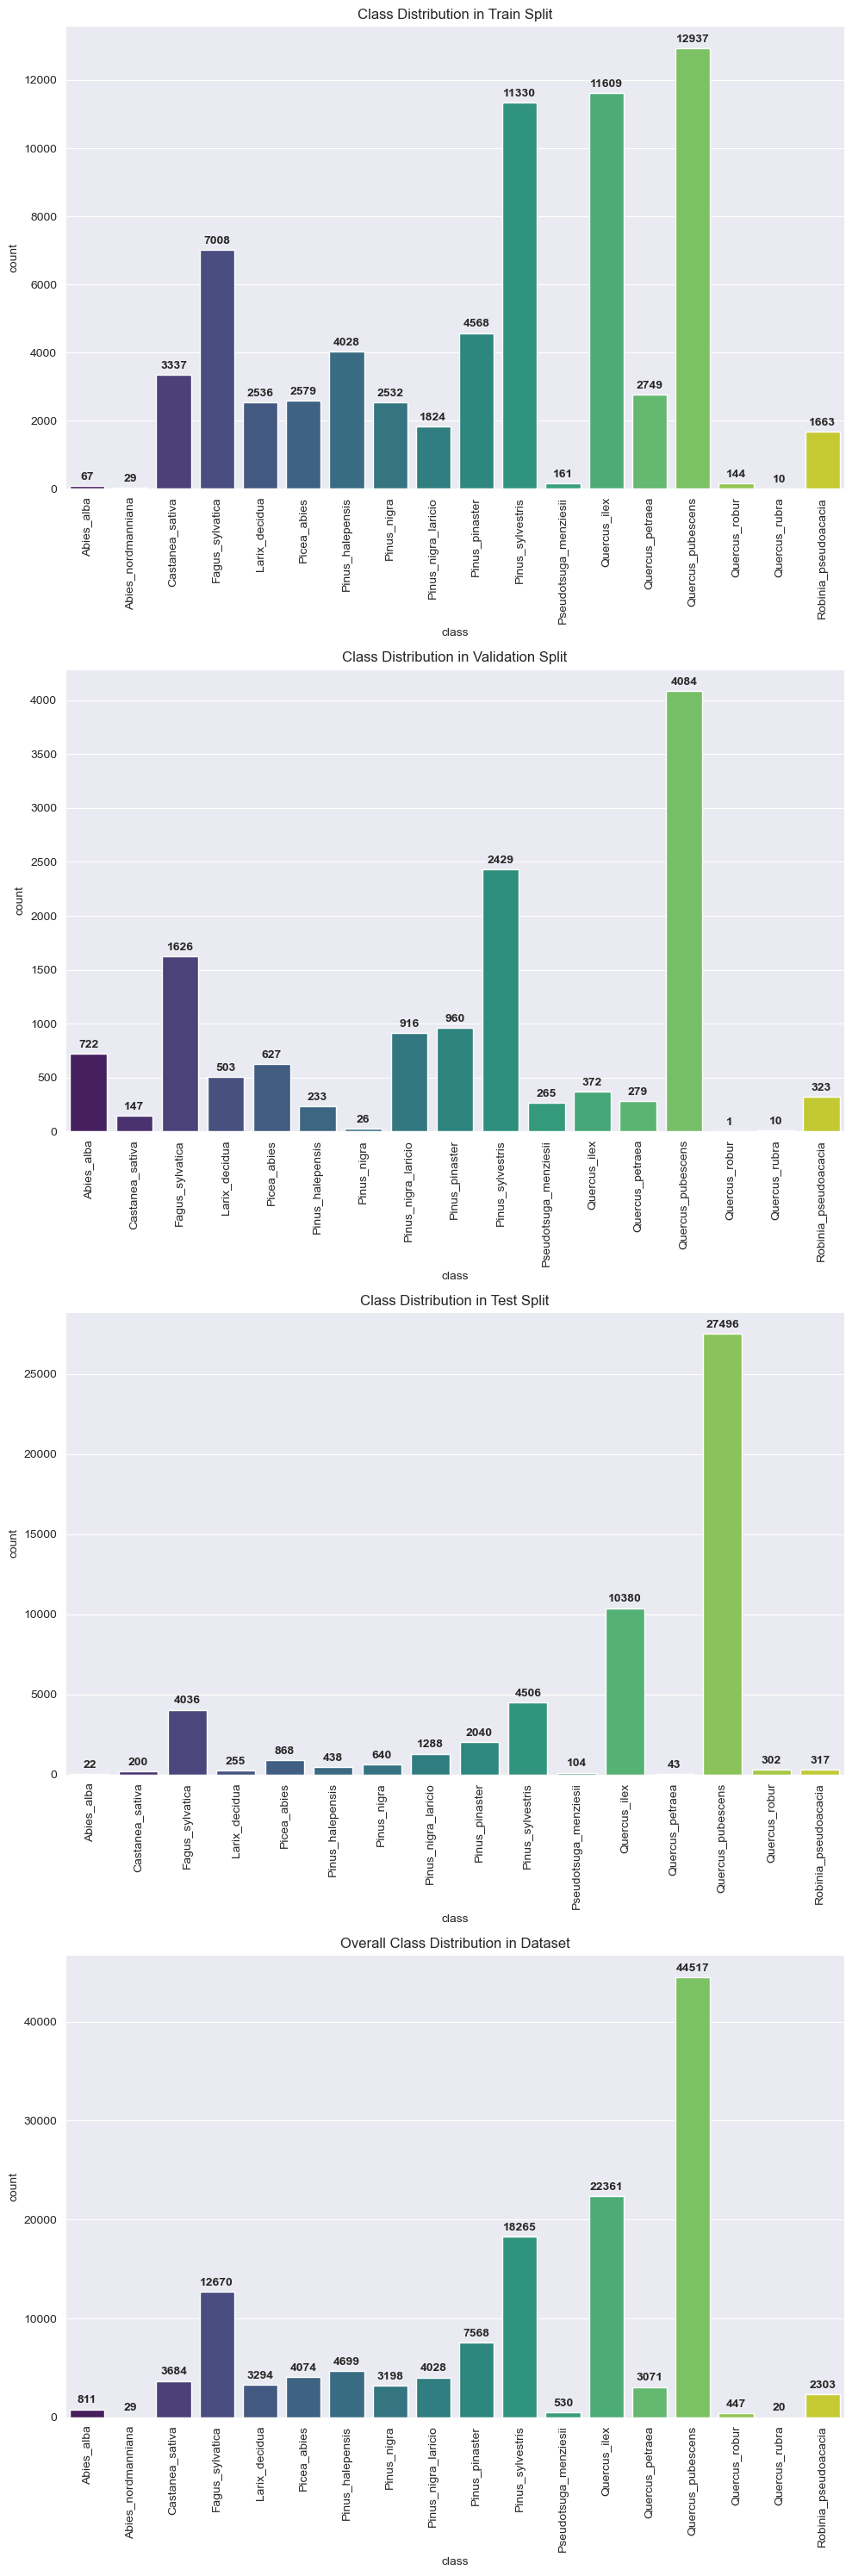

In [54]:
train_df = dataset[dataset["split"] == "train"]
test_df = dataset[dataset["split"] == "test"]
val_df = dataset[dataset["split"] == "val"]

fig, axes = plt.subplots(4, 1, figsize=(10, 30))  # Increased figure size


def plot_class_distribution(df, title, ax):
    sns.countplot(data=df, x="class", hue="class", palette="viridis", ax=ax)

    for container in ax.containers:
        ax.bar_label(container, label_type="edge", fontsize=10, fontweight="bold", padding=3)

    ax.set_title(title)
    ax.tick_params(axis="x", rotation=90)  # Correct way to rotate x-tick labels


plot_class_distribution(train_df, "Class Distribution in Train Split", axes[0])
plot_class_distribution(val_df, "Class Distribution in Validation Split", axes[1])
plot_class_distribution(test_df, "Class Distribution in Test Split", axes[2])
plot_class_distribution(dataset, "Overall Class Distribution in Dataset", axes[3])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [93]:
import rasterio
from tqdm import tqdm


def analyze_channel_intensities(df):
    """Analyze channel intensities across the dataset."""
    channel_stats = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        with rasterio.open(row["paths"]) as src:
            image = src.read()  # Shape: (channels, height, width)
            stats = {
                "mean": np.mean(image, axis=(1, 2)),
                "std": np.std(image, axis=(1, 2)),
                "min": np.min(image, axis=(1, 2)),
                "max": np.max(image, axis=(1, 2)),
                "class": row["class"],
                "split": row["split"],
            }
            channel_stats.append(stats)

    return pd.DataFrame(channel_stats)


def compute_channel_averages(channel_stats_df):
    """Compute average values for each channel across all species.

    Args:
        channel_stats_df (pd.DataFrame): DataFrame containing channel statistics

    Returns:
        pd.DataFrame: DataFrame with computed channel averages
    """
    # Create a new DataFrame to store the results
    result_df = channel_stats_df.copy()

    # Compute channel-specific statistics
    for channel in range(4):
        # Extract values for this channel
        means = [vals[channel] for vals in channel_stats_df["mean"]]
        stds = [vals[channel] for vals in channel_stats_df["std"]]
        mins = [vals[channel] for vals in channel_stats_df["min"]]
        maxs = [vals[channel] for vals in channel_stats_df["max"]]

        # Add channel-specific columns
        result_df[f"ch_{channel}_mean"] = means
        result_df[f"ch_{channel}_std"] = stds
        result_df[f"ch_{channel}_min"] = mins
        result_df[f"ch_{channel}_max"] = maxs

    result_df.drop(columns=["mean", "std", "min", "max"], inplace=True)
    return result_df


def plot_channel_averages(channel_stats_df, save_path=None):
    """Create visualizations for channel analysis using precomputed statistics.

    Args:
        channel_stats_df (pd.DataFrame): DataFrame containing channel statistics
        save_path (str, optional): Path to save the figure. If None, only displays the plot.
    """
    for channel in range(4):
        fig, ax = plt.subplots(figsize=(12, 6))
        fig.suptitle(f"Channel {channel} Mean Values by Species", fontsize=16, y=1.05)

        # Create a DataFrame for plotting for this channel only
        plot_df = pd.DataFrame({"class": channel_stats_df["class"], "value": channel_stats_df[f"ch_{channel}_mean"], "std": channel_stats_df[f"ch_{channel}_std"]})

        # Sort by median value for better visualization
        class_medians = plot_df.groupby("class", observed=True)["value"].median()
        plot_df["class"] = pd.Categorical(plot_df["class"], categories=class_medians.sort_values(ascending=False).index)

        # Create boxplot
        sns.boxplot(data=plot_df, x="class", y="value", ax=ax, color=sns.color_palette("viridis")[channel], showfliers=False)  # Hide outliers for better readability

        # Add error bars for standard deviation
        means = plot_df.groupby("class", observed=True)["value"].mean()
        stds = plot_df.groupby("class", observed=True)["std"].mean()
        x_coords = range(len(means))
        ax.errorbar(x_coords, means, yerr=stds, fmt="none", color="red", capsize=3, label="Std Dev")
        ax.legend()

        # Set x-axis labels with proper rotation
        ax.set_xticks(range(len(plot_df["class"].unique())))
        ax.set_xticklabels(plot_df["class"].unique(), rotation=45, ha="right")
        ax.set_xlabel("Species")
        ax.set_ylabel("Mean Value")

        # Add median values on top of boxes
        medians = plot_df.groupby("class", observed=True)["value"].median()
        for i, median in enumerate(medians):
            ax.text(i, median, f"{median:.2f}", ha="center", va="bottom", fontsize=8)

        plt.tight_layout()

        if save_path:
            # Create channel-specific filename
            file_path = os.path.splitext(save_path)
            channel_path = f"{file_path[0]}_channel_{channel}{file_path[1]}"
            plt.savefig(channel_path, dpi=300, bbox_inches="tight")
        plt.show()

## Analyze channel intensities

In [92]:
channel_stats_df = analyze_channel_intensities(dataset)

In [87]:
channel_stats = compute_channel_averages(channel_stats_df)

In [88]:
channel_stats.to_csv(dataset_folder / "channel_stats.csv", index=False)
channel_stats.head()

class  split  ch_0_mean   ch_0_std  ch_0_min  ch_0_max  ch_1_mean  \
0  Abies_alba  train  86.900656  44.932880         0       221  76.439968   
1  Abies_alba  train  74.308368  44.921979         0       255  71.654512   
2  Abies_alba  train  69.362544  45.837922         0       233  67.659616   
3  Abies_alba  train  67.628816  45.405319         0       228  63.977136   
4  Abies_alba  train  61.055920  41.049592         0       193  61.527792   

    ch_1_std  ch_1_min  ch_1_max  ch_2_mean   ch_2_std  ch_2_min  ch_2_max  \
0  43.507062        15       220  82.913840  38.708941        17       226   
1  42.834673        15       255  78.254416  37.539218        16       255   
2  42.581182        16       235  74.864016  37.042355        16       240   
3  40.514699        15       226  71.872432  35.802123        16       234   
4  40.127556         9       201  68.904720  35.380819        12       198   

   ch_3_mean   ch_3_std  ch_3_min  ch_3_max  
0  72.651232  34.216898         0       246  
1  70.431888  33.386913         0       255  
2  67.528656  32.139898         0       255  
3  64.715664  31.564208         1       255  
4  62.580832  31.618558         0       216

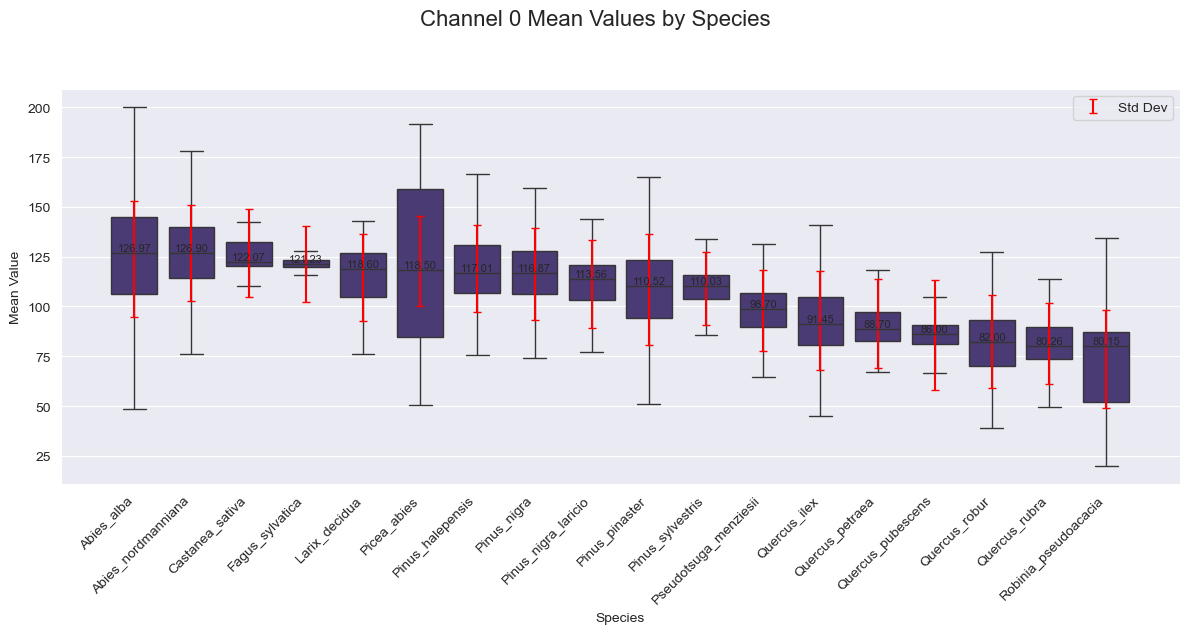

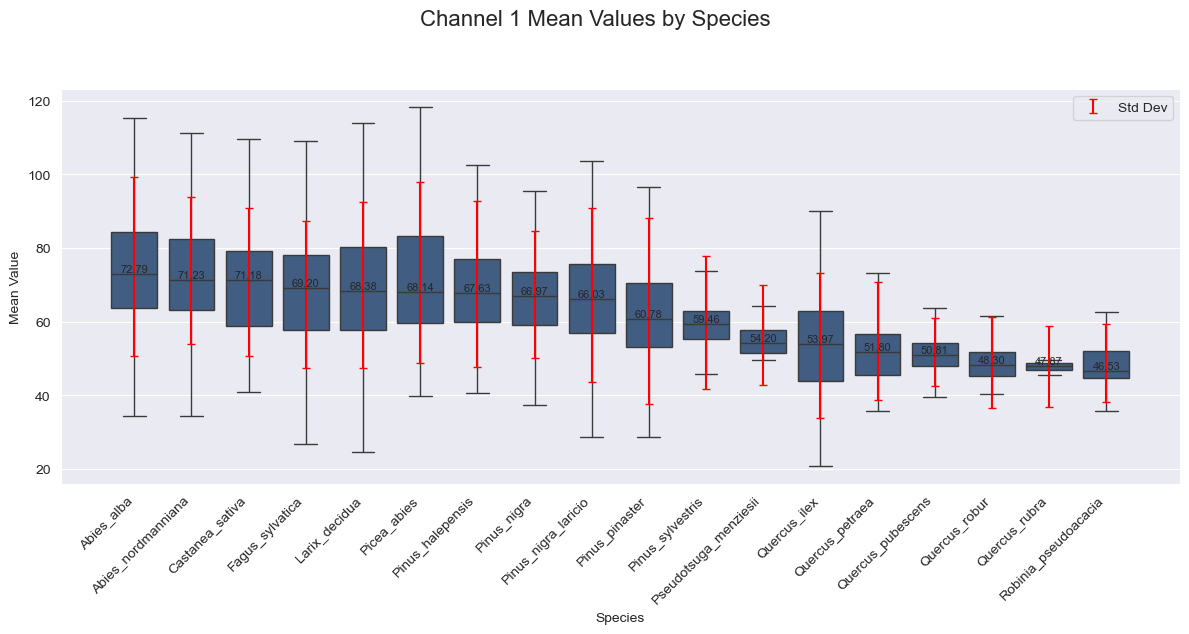

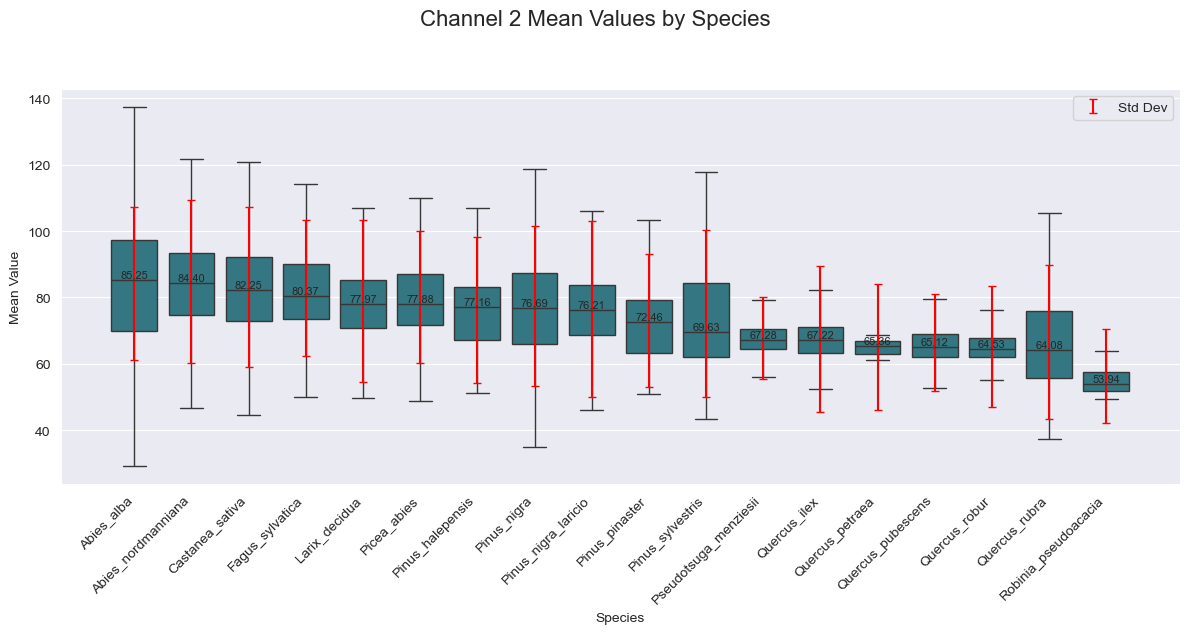

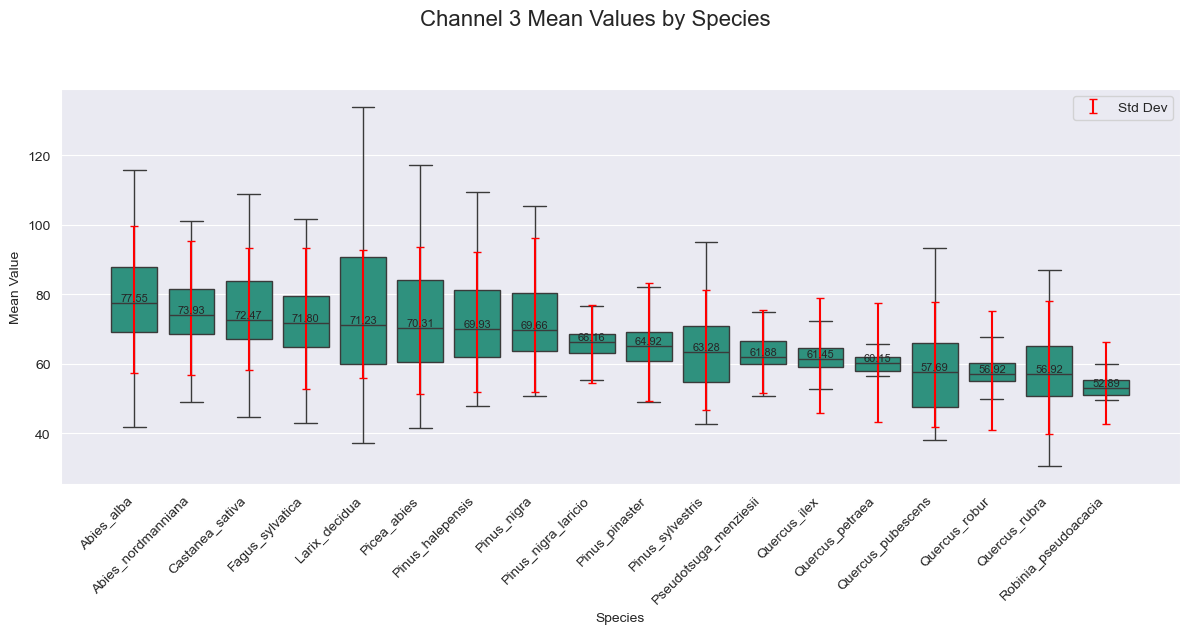

In [94]:
plot_channel_averages(channel_stats)

In [129]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def load_image(path):
    with rasterio.open(path) as src:
        # Read the image and transpose to match tiff.imread shape (height, width, channels)
        return src.read().transpose(1, 2, 0)

In [158]:
# Function to visualize random images per class
def plot_sample_images(ds, split, num_classes=5, ax=None):
    # First get the split data
    split_data = ds[ds["split"] == split]

    # Get indices for each class and filter out empty classes
    class_indices = {cls: np.where(np.array(split_data["labels"]) == cls)[0] for cls in range(num_classes)}
    valid_classes = {cls: indices for cls, indices in class_indices.items() if len(indices) > 0}

    # Create the figure and axes only for valid classes if no axis provided
    num_valid_classes = len(valid_classes)
    if ax is None:
        fig, axes = plt.subplots(num_valid_classes, 4, figsize=(12, num_valid_classes * 3))
        if num_valid_classes == 1:
            axes = axes.reshape(1, -1)
    else:
        axes = ax

    for i, (cls, indices) in enumerate(valid_classes.items()):
        # Get the path for the first image of this class
        img_path = split_data.iloc[indices[0]]["paths"]
        img = load_image(img_path)

        for j in range(4):  # Show all 4 channels (NIR, Red, Green, Blue)
            axes[i, j].imshow(img[:, :, j], cmap="gray")
            axes[i, j].set_title(f"Class {cls} - Band {j}")
            axes[i, j].axis("off")

    if ax is None:
        plt.tight_layout()
        plt.show()


# SIFT Feature Extraction
def plot_sift_features(ds, split, num_samples=5, ax=None):
    split_df = ds[ds["split"] == split]
    sift = cv2.SIFT_create()
    if ax is None:
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    else:
        axes = ax
    paths = np.random.choice(split_df["paths"], num_samples, replace=False)
    for i, path in enumerate(paths):
        img = load_image(path)
        gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_RGB2GRAY)  # Convert first 3 channels to grayscale
        keypoints, _ = sift.detectAndCompute(gray, None)
        img_sift = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(img_sift, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"{split.capitalize()} Split - Sample {i + 1}")
    if ax is None:
        plt.suptitle(f"SIFT Features Visualization - {split.capitalize()} Split", y=1.05)
        plt.tight_layout()
        plt.show()


# PCA Visualization
def plot_pca(ds, split, num_samples=5000, ax=None):
    split = ds[ds["split"] == split]
    paths = np.random.choice(split["paths"], num_samples, replace=False)
    data = np.array([load_image(path).reshape(-1) for path in paths])
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(data)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA Projection")
    if ax is None:
        plt.show()


# t-SNE Visualization
def plot_tsne(ds, split, num_samples=5000, ax=None):
    split = ds[ds["split"] == split]
    paths = np.random.choice(split["paths"], num_samples, replace=False)
    data = np.array([load_image(path).reshape(-1) for path in paths])
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    transformed = tsne.fit_transform(data)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5)
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
    ax.set_title("t-SNE Projection")
    if ax is None:
        plt.show()


# Correlation Matrix
def plot_correlation_matrix(ds, split, num_samples=1000, ax=None):
    split_df = ds[ds["split"] == split]
    paths = np.random.choice(split_df["paths"], num_samples, replace=False)
    data = np.array([load_image(path).mean(axis=(0, 1)) for path in paths])
    corr_matrix = np.corrcoef(data, rowvar=False)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", xticklabels=["NIR", "Red", "Green", "Blue"], yticklabels=["NIR", "Red", "Green", "Blue"], ax=ax)
    ax.set_title(f"Channel Correlation Matrix - {split.capitalize()} Split")
    if ax is None:
        plt.show()


# Execute the EDA functions
splits = ["train", "val", "test"]

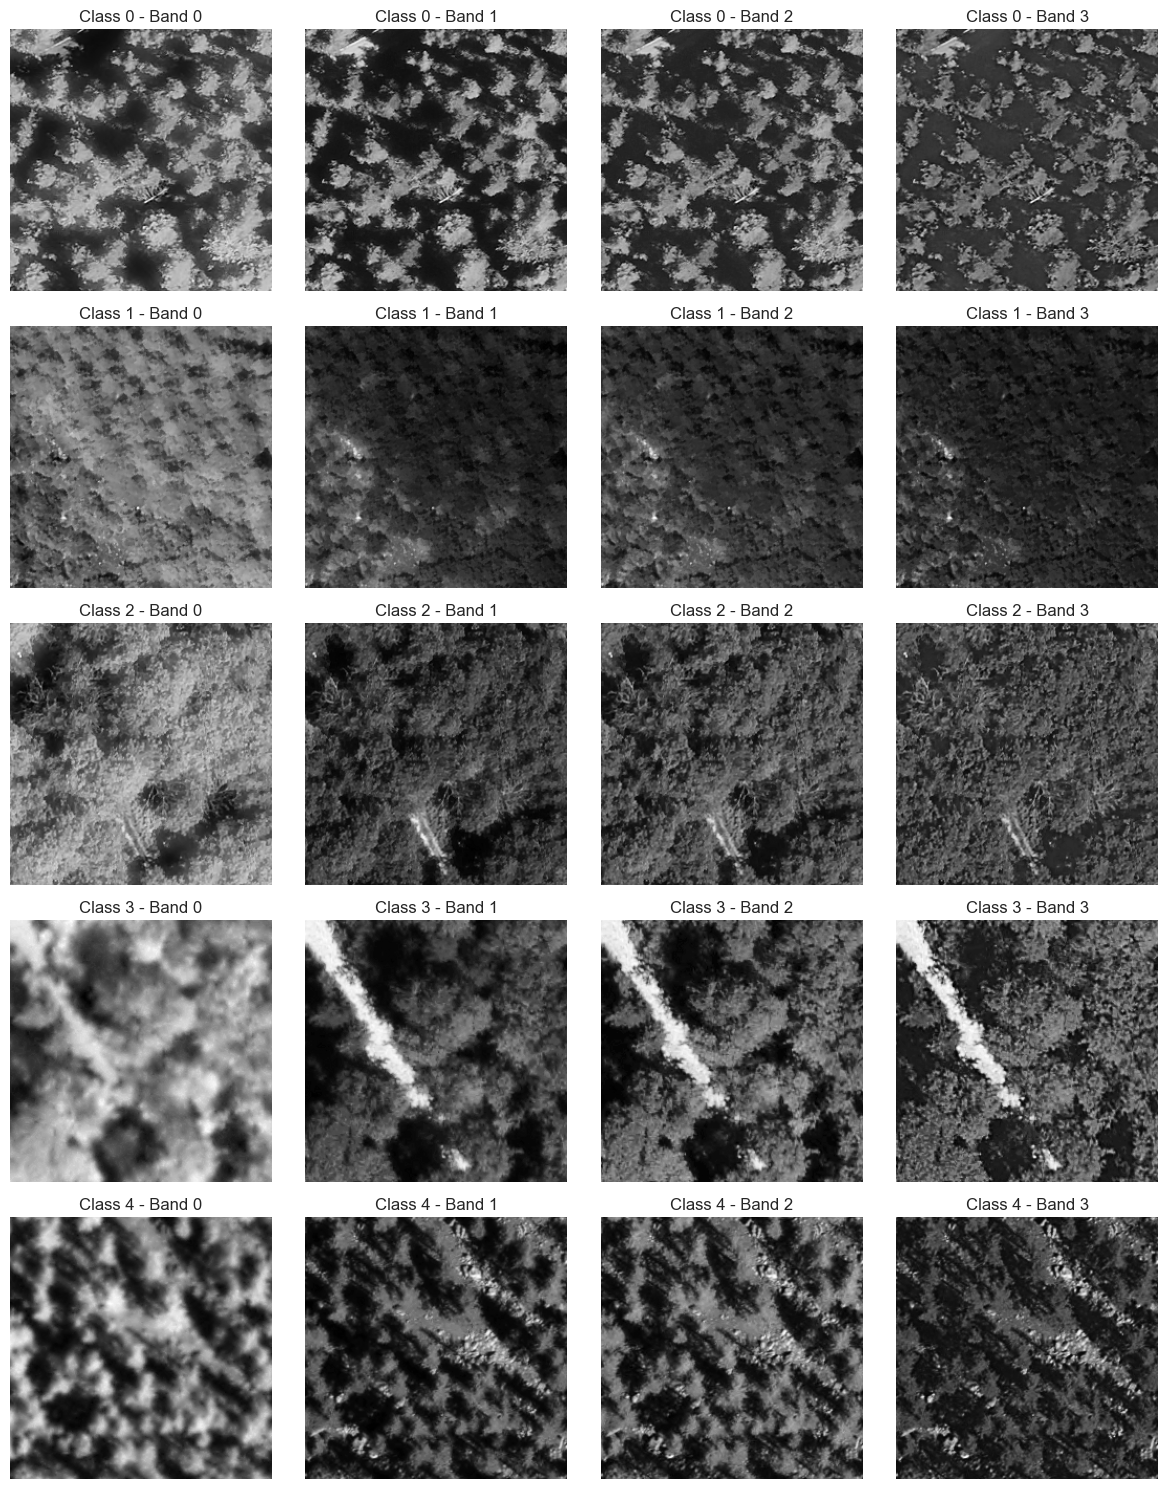

In [142]:
plot_sample_images(dataset, "train")

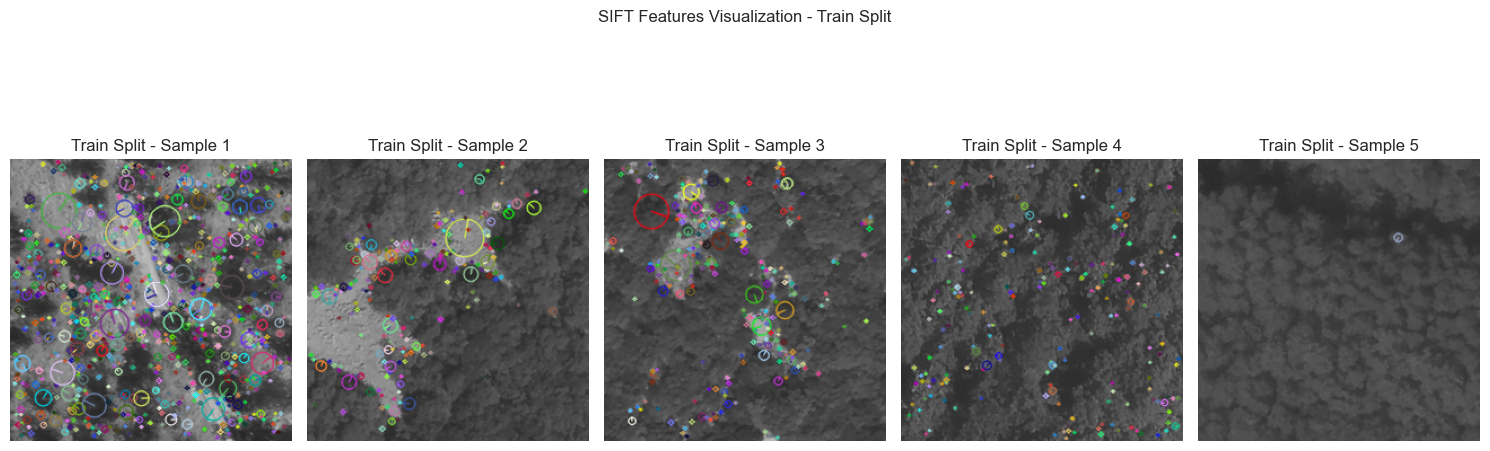

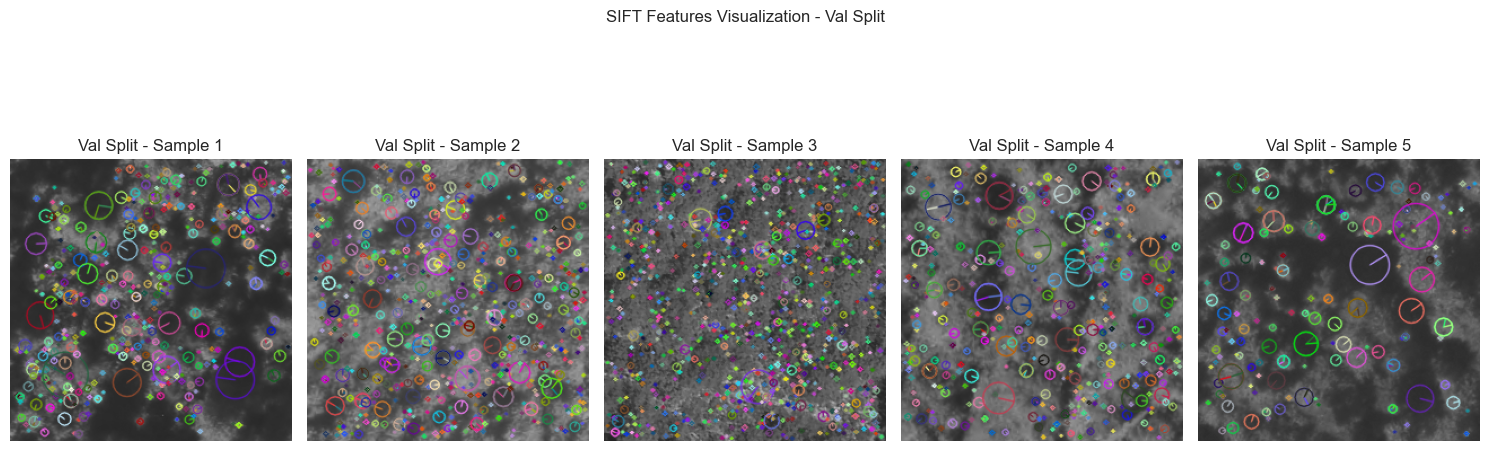

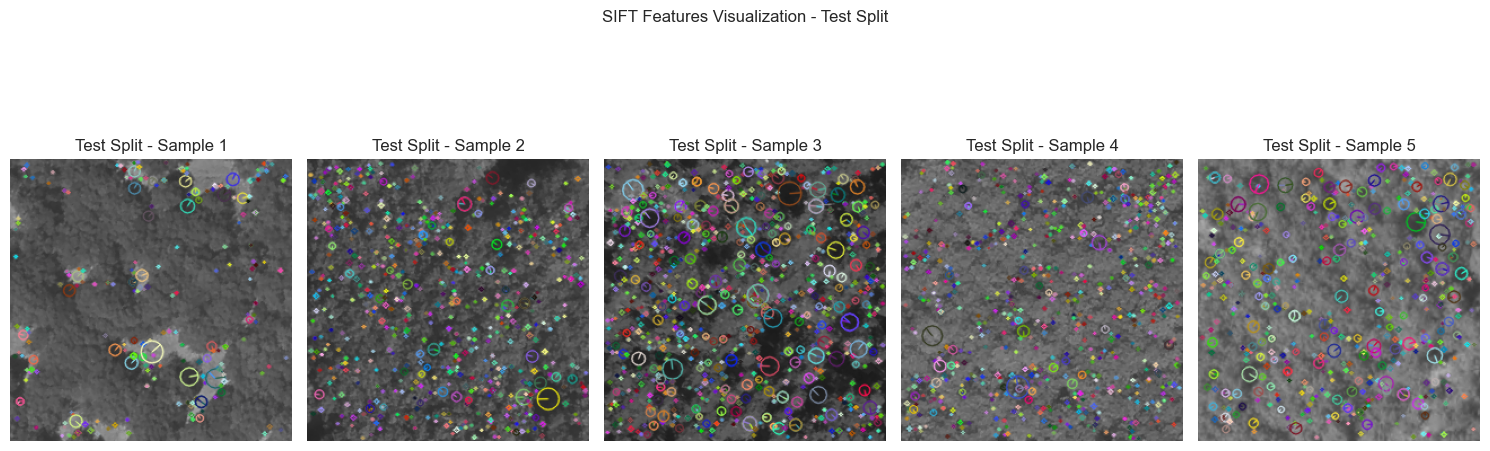

In [159]:
for split in splits:
    plot_sift_features(dataset, split, num_samples=5)

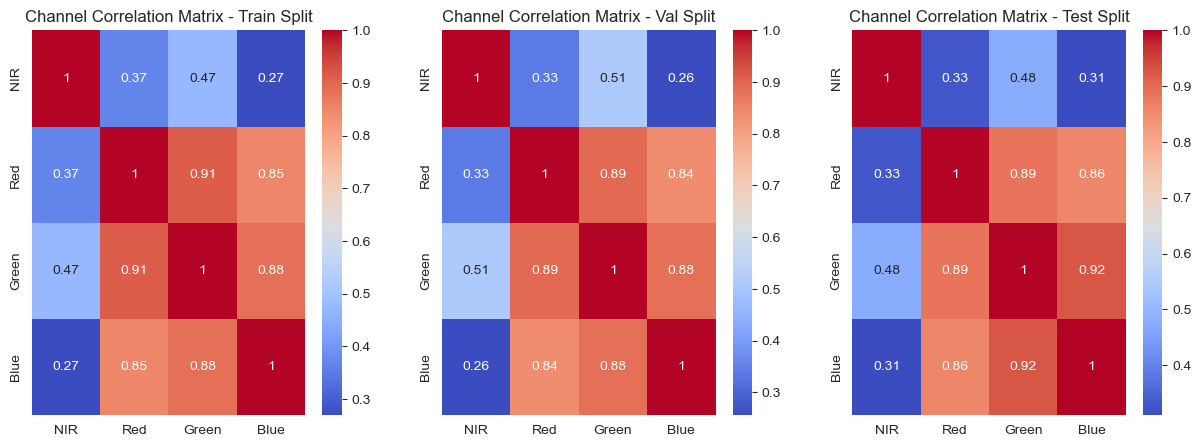

In [160]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_correlation_matrix(dataset, "train", num_samples=1000, ax=axes[0])
plot_correlation_matrix(dataset, "val", num_samples=1000, ax=axes[1])
plot_correlation_matrix(dataset, "test", num_samples=1000, ax=axes[2])
fig.suptitle("Channel Correlations Across Dataset Splits", fontsize=14, y=1.05)
fig.tight_layout()
plt.show()

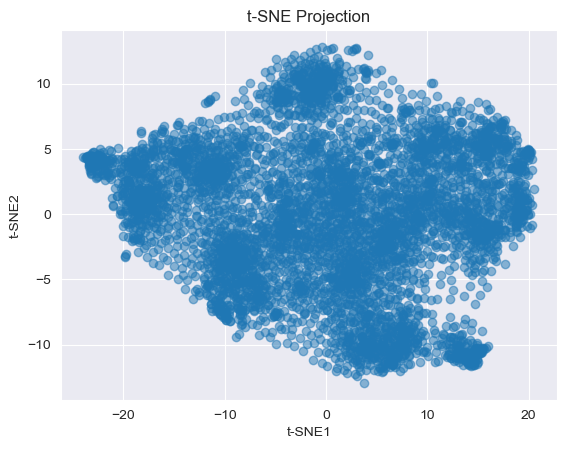

In [161]:
plot_tsne(dataset, "train", num_samples=5000)

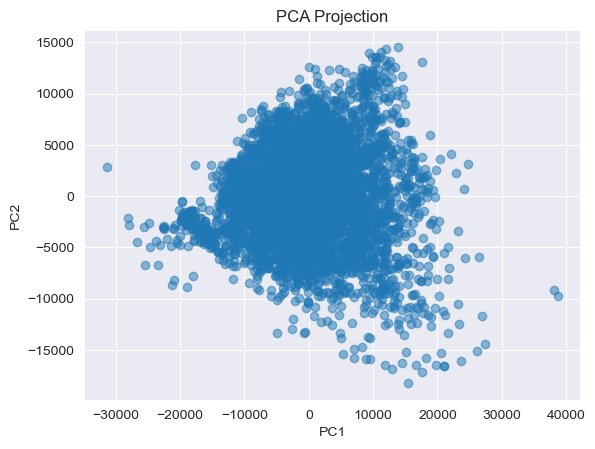

In [162]:
plot_pca(dataset, "train", num_samples=5000)